# Modelo de Regresión Múltiple

In [1]:
#from pyspark import SparkContext
#sc = SparkContext()
#from pyspark.sql import SQLContext
#sqlContext=SQLContext(sc)

In [2]:
bd5 = sqlContext.read.format(
    "com.databricks.spark.csv"
).option("header", "true").load("file:/home/cloudera/Documents/Ficheros de trabajo/bd5.csv", inferSchema=True)
sqlContext.registerDataFrameAsTable(bd5, "bd5")

bd5 = bd5.withColumn('Horario1',(bd5.Horario==1) 
).withColumn('Horario2',(bd5.Horario==2) 
).withColumn('Horario3',(bd5.Horario==3))

bd5 = bd5.withColumn('DepDelay2',(bd5.DepDelay**2)
).withColumn('DepD_Distance',(bd5.DepDelay * bd5.Distance)) 

## Descripción Previa de la Base de Datos

Resumen Numérico

In [3]:
pdf5 = bd5.sample(False, 0.1, 0).select('ArrDelay','DepDelay','DayOfWeek','CRSDepTime','DepDelay2','DepD_Distance').toPandas()
pdf5.corr()

,ArrDelay,DepDelay,DayOfWeek,CRSDepTime,DepDelay2,DepD_Distance
ArrDelay,1.000000,0.959840,0.054927,0.121811,0.742436,0.835426
DepDelay,0.959840,1.000000,0.051572,0.115697,0.775680,0.886463
DayOfWeek,0.054927,0.051572,1.000000,-0.037421,0.019880,0.061005
CRSDepTime,0.121811,0.115697,-0.037421,1.000000,0.037993,0.091446
DepDelay2,0.742436,0.775680,0.019880,0.037993,1.000000,0.638278
DepD_Distance,0.835426,0.886463,0.061005,0.091446,0.638278,1.000000


Configuración de la Base de Datos

In [4]:
from pyspark.ml.feature import VectorAssembler

a1  = VectorAssembler(
    inputCols=['DepDelay','Distance','DayOfWeek',
               'CRSDepTime','Horario1','Horario2',
               'Horario3','DepDelay2','DepD_Distance'],
    outputCol='features')
bd6 = a1.transform(bd5)

In [5]:
from pyspark.sql.functions import col

bd6 = bd6.select(col("ArrDelay").alias("label"),'features')
bd6.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|-16.0|(9,[1,2,3,5],[174...|
| -9.0|(9,[1,2,3,6],[174...|
|-18.0|[-2.0,1747.0,5.0,...|
|119.0|[130.0,628.0,5.0,...|
|-18.0|[-8.0,628.0,5.0,2...|
| -5.0|[2.0,628.0,5.0,73...|
|  0.0|[11.0,628.0,5.0,1...|
| -7.0|[-2.0,1199.0,6.0,...|
|-21.0|[-3.0,1199.0,6.0,...|
|-13.0|[-3.0,1747.0,6.0,...|
|-15.0|[2.0,1747.0,6.0,9...|
| -9.0|[-4.0,1946.0,6.0,...|
|-14.0|[1.0,1946.0,6.0,1...|
|-14.0|[6.0,1587.0,6.0,1...|
| -7.0|[-4.0,1587.0,6.0,...|
|  6.0|[18.0,1199.0,6.0,...|
|-15.0|(9,[1,2,3,5],[119...|
| -8.0|(9,[1,2,3],[628.0...|
| -4.0|[7.0,628.0,6.0,83...|
| -4.0|[-3.0,628.0,6.0,6...|
+-----+--------------------+
only showing top 20 rows



## Ajuste del modelo

In [6]:
from pyspark.ml.regression import LinearRegression

# Define LinearRegression algorithm
lr = LinearRegression()
model = lr.fit(bd6)
pred = model.transform(bd6)

/usr/lib/spark/python/pyspark/ml/regression.py:123: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


In [7]:
print(model.intercept,model.coefficients)

-4.635889634541887 [1.05553557286,-0.00289488941365,0.135668773288,0.00144922041931,-0.242298226852,1.62235576514,0.159579377181,-1.79458480022e-05,-2.10428631003e-05]


Modelo Predictivo:

$ Y_i = \beta_0 + \beta_1 X_{1i} + ... \beta_p X_{pi} $

In [8]:
pred = pred.withColumn('residual', pred.label-pred.prediction)
pred.show()

+-----+--------------------+-------------------+-------------------+
|label|            features|         prediction|           residual|
+-----+--------------------+-------------------+-------------------+
|-16.0|(9,[1,2,3,5],[174...| -6.211447166863374| -9.788552833136626|
| -9.0|(9,[1,2,3,6],[174...| -7.051058774518492|-1.9489412254815077|
|-18.0|[-2.0,1747.0,5.0,...| -7.959222248442044|-10.040777751557956|
|119.0|[130.0,628.0,5.0,...| 132.38334287706127|-13.383342877061267|
|-18.0|[-8.0,628.0,5.0,2...|-11.071887212260929| -6.928112787739071|
| -5.0|[2.0,628.0,5.0,73...|-2.8753341143510367|-2.1246658856489633|
|  0.0|[11.0,628.0,5.0,1...|  8.028310412873815| -8.028310412873815|
| -7.0|[-2.0,1199.0,6.0,...| -8.690067009954756| 1.6900670099547561|
|-21.0|[-3.0,1199.0,6.0,...| -7.724606984982583|-13.275393015017418|
|-13.0|[-3.0,1747.0,6.0,...| -9.457399338080045|-3.5426006619199555|
|-15.0|[2.0,1747.0,6.0,9...|-3.8933807529877105| -11.10661924701229|
| -9.0|[-4.0,1946.0,6.0,...|-10.57

In [9]:
from pyspark.ml.evaluation import RegressionEvaluator

print(RegressionEvaluator(metricName="rmse").evaluate(pred))
print(RegressionEvaluator(metricName="mae").evaluate(pred))
print(RegressionEvaluator(metricName="r2").evaluate(pred))


15.340617652785411
10.608701507780205
0.9178062697891254


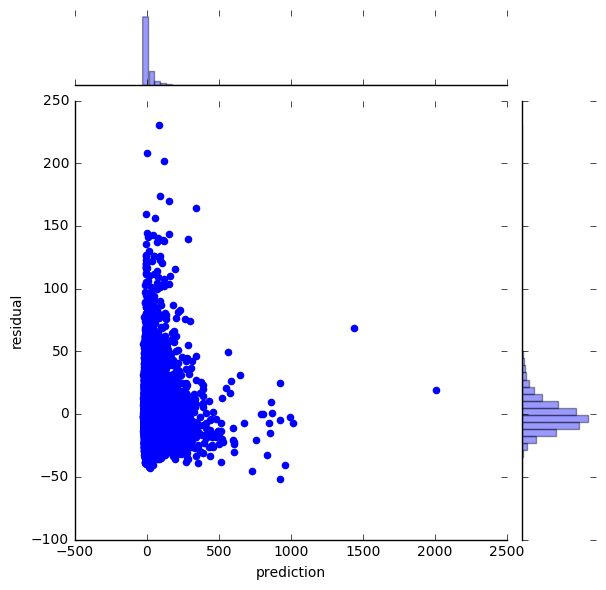

In [10]:
import seaborn as sns
%matplotlib inline

pdpred = pred.toPandas()
sns.jointplot(x="prediction", y="residual", data=pdpred)